# Bias correct CESM2 wind speeds to ERA5 using stress

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range, rotate_vector
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.constants import cesm2_ensemble_members

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
nemo_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20250715.nc').squeeze()
domcfg    = xr.open_dataset(f'{base_dir}bathymetry/domain_cfg-20250715.nc')
land_mask = nemo_mask.tmask.isel(nav_lev=0)

In [3]:
def regrid_to_NEMO(ds, varname, nemo_coord=f'{base_dir}bathymetry/domain_cfg-20240305.nc'):
    
    nemo_coord_file = xr.open_dataset(nemo_coord).squeeze()
    name_remapping  = {'longitude':'lon', 'latitude':'lat'}

    try:
        source_var = ds.rename(name_remapping).sortby('lat').sel(lat=slice(-90, -50))
    except:
        source_var = ds.sortby('lat').sel(lat=slice(-90, -50))
        
    if source_var.lon.max() > 180: # Convert longitudes from 0-360 to -180 to 180 
        source_var['lon'] = fix_lon_range(source_var.lon)
    source_var = source_var.sortby('lon')[varname]
    source_var = xr.where(source_var==0, np.nan, source_var)

    # Now wrap up into a new dataset and interpolate
    ds_source = xr.Dataset({'lon':source_var['lon'], 'lat':source_var['lat'], varname:source_var})
    print('Interpolating')
    interp_src = interp_latlon_cf(ds_source, nemo_coord_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
    
    return interp_src

In [4]:
def process_atm_input(ds, var):

    #ds = ds.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='time')

    ds_nemo = regrid_to_NEMO(ds, var)
    ds_nemo = ds_nemo.where(land_mask!=0)
    
    return ds_nemo

In [14]:
def calc_ensemble_mean_wind(start_year=1979, end_year=2023, save=False):

    varx = 'U10x'; vary='U10y'
    ens_strs = cesm2_ensemble_members
    cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/processed/'
    
    # Load all ensemble files for specified dates and ensemble members into xarray datasets
    for e, ens in enumerate(ens_strs):
        print(ens)
        cesm2_u = xr.open_mfdataset([f'{cesm2_dir}CESM2-LE2_ens{ens}_{varx}_y{year}.nc' for year in range(start_year,end_year+1)])
        cesm2_v = xr.open_mfdataset([f'{cesm2_dir}CESM2-LE2_ens{ens}_{vary}_y{year}.nc' for year in range(start_year,end_year+1)])
    
        if e==0:
            cesm2_u10 = cesm2_u.copy().expand_dims(dim="ens")
            cesm2_v10 = cesm2_v.copy().expand_dims(dim="ens")
        else:
            cesm2_u10 = xr.concat([cesm2_u10, cesm2_u], dim='ens')
            cesm2_v10 = xr.concat([cesm2_v10, cesm2_v], dim='ens')

    # cesm2_u10 = cesm2_u10.assign({'ens':ens_strs})
    # cesm2_v10 = cesm2_v10.assign({'ens':ens_strs})

    cesm2_u10_mean = cesm2_u10.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='ens').groupby("time.month").mean(dim="time")
    cesm2_v10_mean = cesm2_v10.sortby('lat').sel(lat=slice(-90,-50)).mean(dim='ens').groupby("time.month").mean(dim="time")
    if save: 
        # cesm2_u10_mean.load().to_netcdf(f'{cesm2_dir}CESM2-LE2_u10_ensemble_mean_monthly.nc')
        cesm2_v10_mean.load().to_netcdf(f'{cesm2_dir}CESM2-LE2_v10_ensemble_mean_monthly.nc')
    
    return cesm2_u10_mean, cesm2_v10_mean 

### Calculate multiplier

In [ ]:
cesm2_u10_mean, cesm2_v10_mean = calc_ensemble_mean_wind(save=True)

1011.001
1031.002
1051.003
1071.004
1091.005
1111.006
1131.007
1151.008
1171.009
1191.010
1231.011
1231.012
1231.013
1231.014
1251.011
1251.012
1251.013
1251.014
1281.011
1281.012
1281.013
1281.014
1301.011
1301.012
1301.013
1301.014


In [ ]:
start_year=1979
end_year=2023
# leave out 1996 because of Amundsen Sea cyclone issue
years = list(range(start_year,end_year+1)).remove('1996')

In [ ]:
print(years)

In [ ]:
start_year=1979
end_year=2023
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/processed/'
era5_dir  = f'{base_dir}ERA5-forcing/daily/files/processed/'

name_remapping = {'longitude':'lon', 'latitude':'lat'}
era5_u = xr.open_mfdataset([f'{era5_dir}u10_time_y{year}.nc' for year in years]).rename(name_remapping).sortby('lat').sel(lat=slice(-90,-50))
era5_v = xr.open_mfdataset([f'{era5_dir}v10_time_y{year}.nc' for year in years]).rename(name_remapping).sortby('lat').sel(lat=slice(-90,-50))

# cesm2_u10_monthly = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_u10_ensemble_mean_monthly.nc')
# cesm2_v10_monthly = xr.open_dataset(f'{cesm2_dir}CESM2-LE2_v10_ensemble_mean_monthly.nc')

In [ ]:
era5_u_monthly  = era5_u.u10.groupby("time.month").mean(dim="time")
era5_v_monthly  = era5_v.v10.groupby("time.month").mean(dim="time")

cesm2_u_monthly = cesm2_u10_mean.U10x
cesm2_v_monthly = cesm2_v10_mean.U10y

cesm2_speed     = np.sqrt(cesm2_u_monthly**2 + cesm2_v_monthly**2).rename('wind_speed').to_dataset()
era5_speed      = np.sqrt(era5_u_monthly**2 + era5_v_monthly**2).rename('wind_speed').to_dataset()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '')

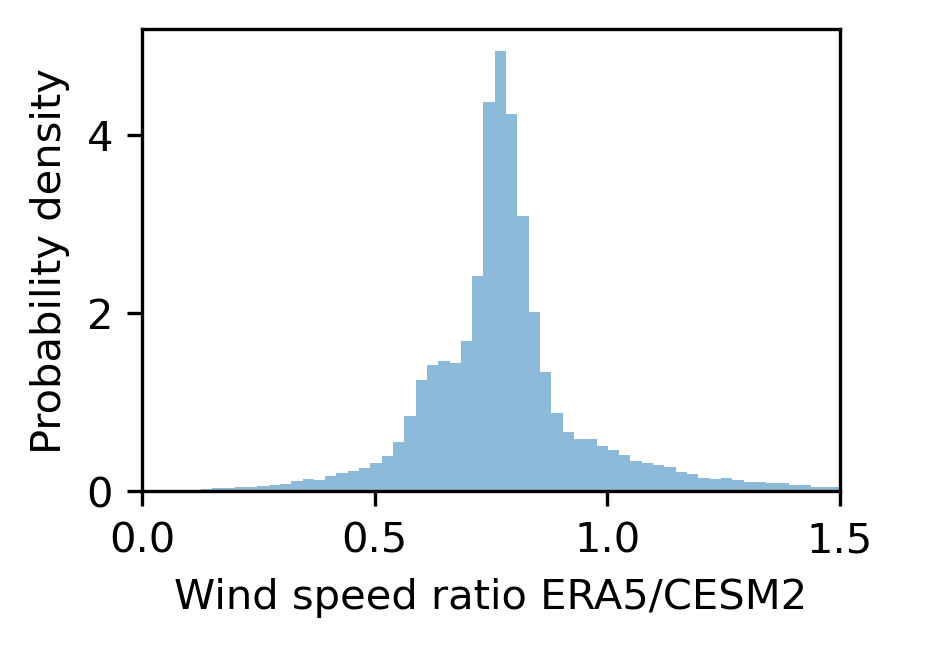

In [31]:
fig, ax = plt.subplots(3,4, figsize=(12,16))
kwags2={'density':True, 'alpha':0.5, 'bins':2000}
for m, axis in enumerate(ax.ravel()):
    print(m)
    if m==0:
        cesm2_speed_nemo = process_atm_input(cesm2_speed.isel(month=m), 'wind_speed')
        era5_speed_nemo  = process_atm_input(era5_speed.isel(month=m), 'wind_speed')
        
        (era5_speed_nemo.wind_speed / cesm2_speed_nemo.wind_speed).plot.hist(ax=axis, **kwags2)
        axis.set_title(f'Month: {m+1}, median ratio = {(era5_speed_nemo.wind_speed/cesm2_speed_nemo.wind_speed).median().values:.2f}')

# ax.legend(loc=(1.05, 0.6), frameon=False)
# ax.set_xlim(0,1.5)
# ax.set_xlabel('Wind speed ratio ERA5/CESM2')
# ax.set_ylabel('Probability density')
# ax.set_title('')

### Also look at whether there's a consistent spatial seasonal bias in wind speeds

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(12,16))
for m, axis in enumerate(ax.ravel()):
    print(m)
    if m==0:
        cesm2_speed_nemo = process_atm_input(cesm2_speed.isel(month=m), 'wind_speed')
        era5_speed_nemo  = process_atm_input(era5_speed.isel(month=m), 'wind_speed')
        
        (era5_speed_nemo.wind_speed / cesm2_speed_nemo.wind_speed).plot(ax=axis, vmin=0, vmax=2)
        axis.set_title(f'Month: {m+1}')